In [2]:
import pandas as pd
#import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer


## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

In [3]:
import numpy as np

In [183]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
datapath = '../data/interim/'

In [5]:
train_df = pd.read_csv(datapath + 'interim_train_df.csv')

In [6]:
train_df.head()

text  Disaster
0  Our Deeds are the Reason of this #earthquake M...         1
1             Forest fire near La Ronge Sask. Canada         1
2  All residents asked to 'shelter in place' are ...         1
3  13,000 people receive #wildfires evacuation or...         1
4  Just got sent this photo from Ruby #Alaska as ...         1

In [7]:
test_df = pd.read_csv(datapath + 'interim_test_df.csv')
test_df.head()

text
0                 Just happened a terrible car crash
1  Heard about #earthquake is different cities, s...
2  there is a forest fire at spot pond, geese are...
3           Apocalypse lighting. #Spokane #wildfires
4      Typhoon Soudelor kills 28 in China and Taiwan

## Preprocessing Tweets

In [8]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [9]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r"http\S+", "", text) #remove urls
    text = re.sub('#[^\s]+','', text) #remove hashtags
    text = re.sub('@[^\s]+','', text) #remove tags
    text = re.sub(r'[0-9]+','', text) #remove digits

            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text


# Modeling using Bag of Words 

In [10]:
train_df["text"] = train_df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
train_df.head()

text  Disaster
0         deed reason earthquake may allah forgive u         1
1              forest fire near la ronge sask canada         1
2  resident asked shelter place notified officer ...         1
3  people receive wildfire evacuation order calif...         1
4  got sent photo ruby alaska smoke wildfire pour...         1

In [12]:
(train_df.text == "" ).sum()  # check for empty tweets after preprocessing

0

In [340]:
test_df["text"] = test_df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
test_df.head()

text
0                        happened terrible car crash
1  heard earthquake different city stay safe ever...
2  forest fire spot pond goose fleeing across str...
3               apocalypse lighting spokane wildfire
4                 typhoon soudelor kill china taiwan

In [341]:
train_df.columns

Index(['text', 'Disaster'], dtype='object')

In [18]:
# Get the name of dataframe
def get_df_name(df):
    '''Function to get the name of DataFrame'''
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [344]:
y = train_df.Disaster
X = train_df.drop('Disaster', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

data_sets =[X_train, X_val, y_train, y_val]

for d in data_sets:
    print(f'The shape of {get_df_name(d)}: {d.shape} {round(d.shape[0]/train_df.shape[0] *100, 0)}% \n')

The shape of X_train: (5329, 1) 70.0% 

The shape of X_val: (2284, 1) 30.0% 

The shape of y_train: (5329,) 70.0% 

The shape of y_val: (2284,) 30.0% 



### Tf-Idf 

In [16]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

In [26]:
corpus = X_train["text"]
vectorizer.fit(corpus)
# X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

In [58]:
classifier = naive_bayes.MultinomialNB(alpha=0.5)

In [65]:
mnb_pipeline = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

grid_params = {
  'classifier__alpha': np.linspace(0.1, 2, 10),
  'classifier__fit_prior': [True, False],
  'vectorizer__max_df': np.linspace(0.1, 1, 10),
  'vectorizer__binary': [True, False],
  'vectorizer__norm': [None, 'l1', 'l2'], 
}
clf = model_selection.GridSearchCV(mnb_pipeline, grid_params)
clf.fit(X_train["text"], y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.7950842516009126
Best Params:  {'classifier__alpha': 0.7333333333333333, 'classifier__fit_prior': True, 'vectorizer__binary': False, 'vectorizer__max_df': 0.1, 'vectorizer__norm': 'l2'}


In [69]:
model = clf.best_estimator_

In [383]:
# fitting best model
model.fit(X_train['text'], y_train)


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.1, max_features=10000,
                                 ngram_range=(1, 3))),
                ('classifier', MultinomialNB(alpha=0.7333333333333333))])

In [177]:
# evaluation function
def model_evaluation(model):
    if model == xgb_pipeline:
        X = X_val
    else:
        X = X_val['text']
        
    predicted = model.predict(X)
    predicted_prob = model.predict_proba(X)
    classes = np.unique(y_val)
    y_test_array = pd.get_dummies(y_val, drop_first=False).values

    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_val, predicted)
    auc = metrics.roc_auc_score(y_val, predicted_prob[:,1])
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_val, predicted))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_val, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                               predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(fpr, tpr))
                   )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

Accuracy: 0.8
Auc: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1305
           1       0.88      0.63      0.73       979

    accuracy                           0.80      2284
   macro avg       0.82      0.78      0.79      2284
weighted avg       0.82      0.80      0.80      2284



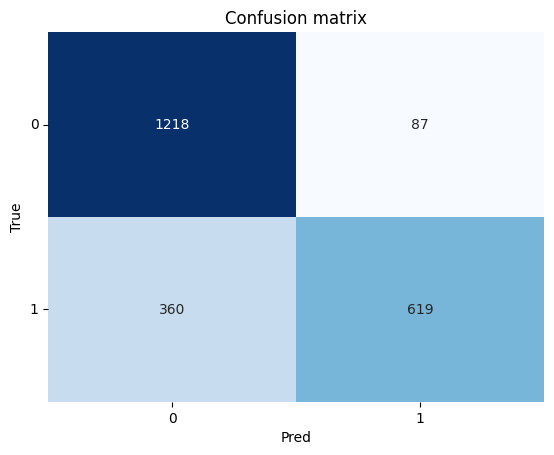

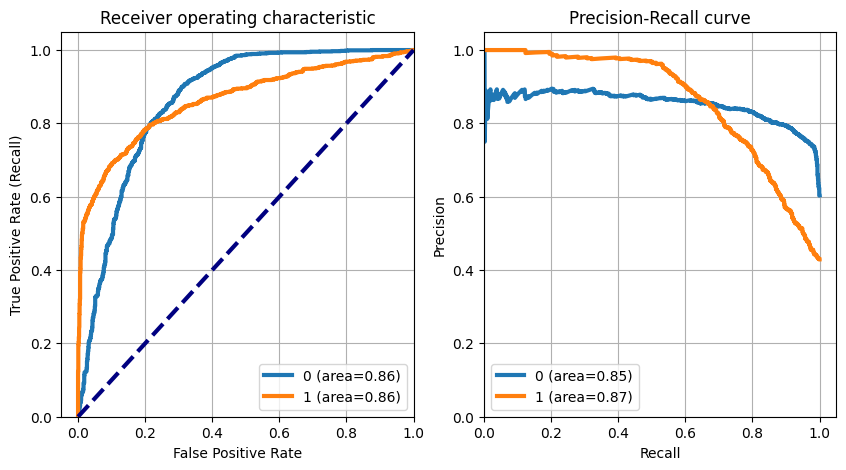

In [385]:
model_evaluation(model)

In [356]:
import os
import sklearn
import pickle
from datetime import datetime

def save_model(model, model_name):
    
    best_model = model
    model_name = model_name+'_'+type(model).__name__
    best_model.version = '1.0'
    best_model.pandas_version = pd.__version__
    best_model.numpy_version = np.__version__
    sklearn_version = sklearn.__version__

    best_model.sklearn_version = sklearn_version
    best_model.X_columns = [col for col in X_train.columns]
    best_model.build_datetime = datetime.now()

    modelpath = '../models'
    if not os.path.exists(modelpath):
        os.mkdir(modelpath)
    bankmodel_path = os.path.join(modelpath, model_name+'.pkl')
    if not os.path.exists(bankmodel_path):
        with open(bankmodel_path, 'wb') as f:
            pickle.dump(best_model, f)
    print(f'Model {model_name} is Saved')

In [91]:
save_model(model, 'MultinomialNB')


Model MultinomialNB_Pipeline is Saved


In [401]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
def load_model(model):
    expected_model_version = '1.0'
    sklearn_version = sklearn.__version__
    model_path = '../models/' + model
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
    
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")

    return model

In [402]:
model =load_model('MultinomialNB_Pipeline.pkl')

In [406]:
model

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.1, max_features=10000,
                                 ngram_range=(1, 3))),
                ('classifier', MultinomialNB(alpha=0.7333333333333333))])

In [72]:
## select observation
true_p = y_val.reset_index()

true_p =true_p[true_p.Disaster == 1].index
for i in np.random.choice(true_p, size=5, replace=False):
        txt_instance = X_val["text"].iloc[i]
        ## check true value and predicted value
        print("\nTrue:", y_val.iloc[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
        ## show explanation
        explainer = lime_text.LimeTextExplainer(class_names=
                     np.unique(y_train))
        explained = explainer.explain_instance(txt_instance, 
                     model.predict_proba, num_features=5)
        explained.show_in_notebook(text=txt_instance, predict_proba=False)


True: 1 --> Pred: 1 | Prob: 0.76



True: 1 --> Pred: 1 | Prob: 0.82



True: 1 --> Pred: 0 | Prob: 0.78



True: 1 --> Pred: 0 | Prob: 0.83



True: 1 --> Pred: 1 | Prob: 0.99


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_pipeline = pipeline.Pipeline([
     ('vectorizer', vectorizer),
    ('lr', LogisticRegression())
])
grid_params = {
  'lr__penalty': [ 'l2'],
  'lr__C': [1, 5, 10],
  'lr__max_iter': [20, 50, 100],
  'vectorizer__max_df': np.linspace(0.1, 1, 10),
  'vectorizer__binary': [True, False],
}
lr = model_selection.GridSearchCV(lr_pipeline, grid_params)
lr.fit(X_train["text"], y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

In [78]:
print("Best Score: ", lr.best_score_)
print("Best Params: ", lr.best_params_)

Best Score:  0.7986503888874208
Best Params:  {'lr__C': 1, 'lr__max_iter': 20, 'lr__penalty': 'l2', 'vectorizer__binary': False, 'vectorizer__max_df': 0.1}


In [83]:
lr_model = lr.best_estimator_
lr_model

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.1, max_features=10000,
                                 ngram_range=(1, 3))),
                ('lr', LogisticRegression(C=1, max_iter=20))])

Accuracy: 0.81
Auc: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1305
           1       0.84      0.69      0.76       979

    accuracy                           0.81      2284
   macro avg       0.82      0.80      0.80      2284
weighted avg       0.81      0.81      0.81      2284



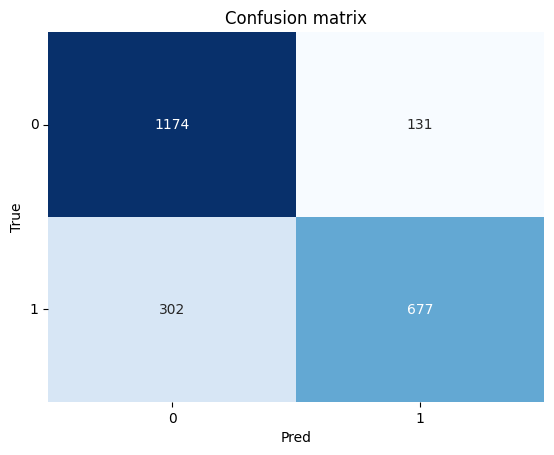

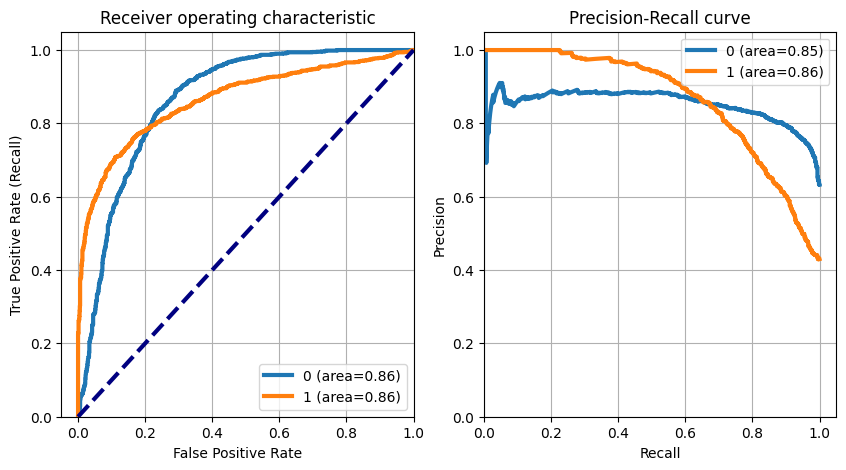

In [82]:
model_evaluation(lr_model)

In [92]:
save_model(lr_model, 'lr')


Model lr_Pipeline is Saved


## XGboost with Bayesian Hyperparameter Optimization

In [12]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [13]:
# RepeatedStratifiedKFold is used for cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [14]:
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD


In [117]:
#df['TotalWords'] = df.text.apply(len)

In [16]:
train_df

text  Disaster
0     Our Deeds are the Reason of this #earthquake M...         1
1                Forest fire near La Ronge Sask. Canada         1
2     All residents asked to 'shelter in place' are ...         1
3     13,000 people receive #wildfires evacuation or...         1
4     Just got sent this photo from Ruby #Alaska as ...         1
...                                                 ...       ...
7608  Two giant cranes holding a bridge collapse int...         1
7609  @aria_ahrary @TheTawniest The out of control w...         1
7610        M1.94 [01:04 UTC]?5km S of Volcano Hawaii.          1
7611  Police investigating after an e-bike collided ...         1
7612  The Latest: More Homes Razed by Northern Calif...         1

[7613 rows x 2 columns]

In [131]:
y = train_df.Disaster
X = train_df[['text']]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

data_sets =[X_train, X_val, y_train, y_val]

for d in data_sets:
    print(f'The shape of {get_df_name(d)}: {d.shape} {round(d.shape[0]/train_df.shape[0] *100, 0)}% \n')

The shape of X_train: (5329, 1) 70.0% 

The shape of X_val: (2284, 1) 30.0% 

The shape of y_train: (5329,) 70.0% 

The shape of y_val: (2284,) 30.0% 



### Create Custom Transformer of Cleaning Tweets to be Added to the Pipeline

In [80]:
utils_preprocess_text??

Signature:
utils_preprocess_text(
    text,
    flg_stemm=False,
    flg_lemm=True,
    lst_stopwords=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few

In [179]:
def preprocess_df(df):
    ''' This function applies text cleaning and returns pandas seriese.
    To be used as custom transformation and addded to the pipeline.
    '''
    df.loc[:, 'text'] =  df.loc[:, 'text'].apply(utils_preprocess_text)
    return df


In [151]:
X_train.text.apply(utils_preprocess_text).shape

(5329,)

In [152]:
preprocess_df(X_train).shape

(5329, 1)

In [153]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self



# this pipeline has a single step
clean_tweets = pipeline.Pipeline([
    ("clean_text", DataframeFunctionTransformer(preprocess_df))
])



In [154]:
clean_tweets.fit_transform(X_train).shape


(5329, 1)

In [117]:
X_train.shape

(5330, 1)

In [24]:
svd = TruncatedSVD(n_components=300,algorithm='randomized', random_state=42)
tfidf = feature_extraction.text.TfidfVectorizer(ngram_range=(1,3),
                        strip_accents='unicode',
                        lowercase =True, analyzer='word',
                        use_idf=True, smooth_idf=True, sublinear_tf=True, 
                        stop_words = 'english')


### Feature Engineering: impute stats (length and number of sentences) of tweets

In [155]:
def text_stats(posts):
    return [{'length': len(text),
             'num_sentences': text.count('.')}
            for text in posts]


text_stats_transformer = FunctionTransformer(text_stats)

In [180]:
from sklearn.pipeline import Pipeline
transformer_pipeline = Pipeline([  
    # clean tweets transformation
    ("clean_text", DataframeFunctionTransformer(preprocess_df)),
    # Use ColumnTransformer to combine the subject and body features
    ('union', ColumnTransformer(
        
        [ 
            
            # bag-of-words with decomposition for tweets (col 0)
            ('body_bow', Pipeline([
                ('tfidf', tfidf),
                ('best', svd),
            ]), 0),
            # Pipeline for pulling text stats from post's body
            ('tweet_stats', Pipeline([
                ('stats', text_stats_transformer),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ]), 0),
        ],
    )),
    # Tuned XGB Model
   # ('clf', xgb_model),
], verbose=True)

In [157]:
X_train_tuning = transformer_pipeline.fit_transform(X_train)

[Pipeline] ........ (step 1 of 2) Processing clean_text, total=   0.4s
[Pipeline] ............. (step 2 of 2) Processing union, total=  13.3s


In [158]:
X_train_tuning.shape

(5329, 302)

In [159]:
transformer_pipeline.steps

[('clean_text', <__main__.DataframeFunctionTransformer at 0x7fe69b6a9a30>),
 ('union',
  ColumnTransformer(transformers=[('body_bow',
                                   Pipeline(steps=[('tfidf',
                                                    TfidfVectorizer(ngram_range=(1,
                                                                                 3),
                                                                    stop_words='english',
                                                                    strip_accents='unicode',
                                                                    sublinear_tf=True)),
                                                   ('best',
                                                    TruncatedSVD(n_components=300,
                                                                 random_state=42))]),
                                   0),
                                  ('tweet_stats',
                                   Pipeline(st

In [161]:
#X_train = transform_pipe.fit_transform(X_train)
def hyperopt_train_test(params):
    

    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = xgb.XGBClassifier(
        objective="binary:logistic", eval_metric="aucpr",
        n_estimators=20,
        scale_pos_weight=2,
        n_jobs=4,
        use_label_encoder=False,

        **params
    )

    
    cv_score = cross_val_score(clf, X_train_tuning, y_train, cv=cv, scoring='accuracy').mean()
    return {'model':clf, 'score': cv_score}

space = {
    'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),


    'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    }

best = 0
def f(params):
    global best
    model = hyperopt_train_test(params)['model']
    score = hyperopt_train_test(params)['score']
    if score > best:
      best = score
      print( 'new best:', best, params)
    return {'loss': 1-score, 'status': STATUS_OK, 'Trained_Model': model}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=20, trials=trials)
print(best)

new best:                                             
0.7417541597301132                                    
{'booster': 'gbtree', 'colsample_bytree': 0.4964743701019735, 'gamma': 0.44696103309864765, 'learning_rate': 0.017339899494615233, 'max_depth': 8.0, 'min_child_weight': 0.005720426409702811, 'num_leaves': 112.0}
new best:                                                                        
0.750872323371121                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.7135197377757536, 'gamma': 0.24084427146234794, 'learning_rate': 0.0234970045780794, 'max_depth': 10.0, 'min_child_weight': 1.2447748488432488e-05, 'num_leaves': 100.0}
100%|██████████| 20/20 [32:46<00:00, 98.31s/trial, best loss: 0.24912767662887902] 
{'booster': 0, 'colsample_bytree': 0.7135197377757536, 'gamma': 0.24084427146234794, 'learning_rate': 0.0234970045780794, 'max_depth': 10.0, 'min_child_weight': 1.2447748488432488e-05, 'num_leaves': 100.0}


In [162]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_Model']

In [163]:
xgb_model = getBestModelfromTrials(trials)
xgb_model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree='0.714',
              eval_metric='aucpr', gamma='0.241', gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=4, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)

In [185]:
xgb_pipeline = Pipeline([  
    # preprocessing and transformation
    ("preprocessing", transformer_pipeline),
   
    # Tuned XGB Model
   ('XGBoost_Classifier', xgb_model),
], verbose=True)

In [186]:
xgb_pipeline.fit(X_train, y_train)


[Pipeline] ........ (step 1 of 2) Processing clean_text, total=   0.5s
[Pipeline] ............. (step 2 of 2) Processing union, total=  14.1s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=  14.6s
[Pipeline]  (step 2 of 2) Processing XGBoost_Classifier, total=   3.5s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('clean_text',
                                  <__main__.DataframeFunctionTransformer object at 0x7fe6957d7340>),
                                 ('union',
                                  ColumnTransformer(transformers=[('body_bow',
                                                                   Pipeline(steps=[('tfidf',
                                                                                    TfidfVectorizer(ngram_range=(1,
                                                                                                                 3),
                                                                                                    stop_words='english',
                                                                                                    strip_accents='unicode',
                                                                                                    sublinear_tf=True)),
 

### Evaluation of XGBoost on the test data set

Accuracy: 0.74
Auc: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1305
           1       0.67      0.77      0.72       979

    accuracy                           0.74      2284
   macro avg       0.74      0.74      0.74      2284
weighted avg       0.75      0.74      0.74      2284



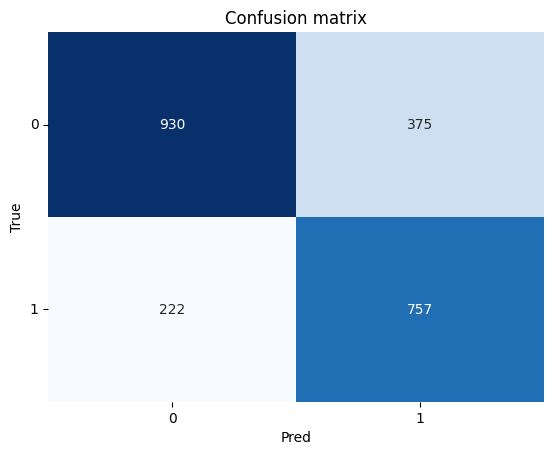

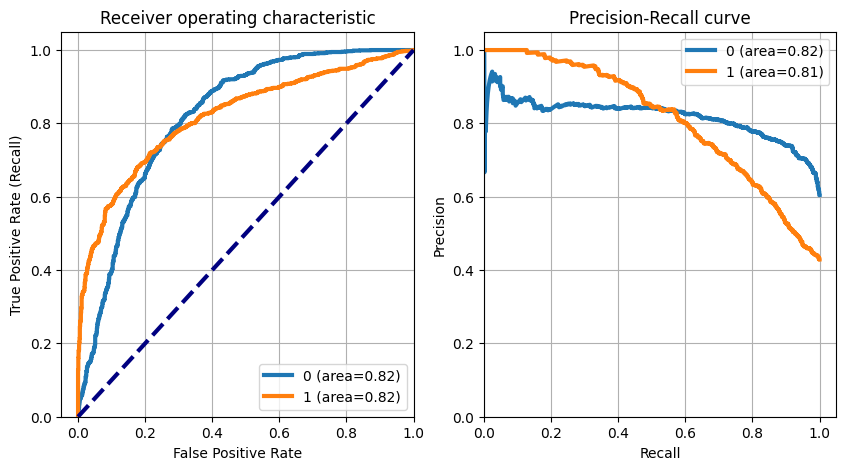

In [187]:
model_evaluation(xgb_pipeline)